## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  
livetime = c['livetime']
folder = c['folder']

In [3]:
dataset  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)

setup = Setup(dataset_input=dataset)
dataset_asimov, dataset_asimov_N = setup.run()
setup.set_irf_model(dataset_asimov_N)
dataset_asimov, dataset_asimov_N  = setup.apply_config_settings(dataset_asimov, dataset_asimov_N, c)
e_reco_n = 1000

dataset_asimov_N.e_reco_n = e_reco_n

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/Dataset/datasets/dataset-simulated-2.154434690031884-hr.fits.gz
reference 1.0


In [4]:
%%time
fitting = 1
if fitting:
    fit_cor = Fit(store_trace=0)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_cor.backend = "minuit"
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov)
    print(result_cor)
    print(dataset_asimov)
    print("saving")
    path = f'../{folder}/data/0_model.yml'
    dataset_asimov.models.write(path,overwrite=True)
    fig = plt.figure()
    dataset_asimov.models.covariance.plot_correlation()
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/0_cov.pdf')
    plt.close()

else:
    path = f'../{folder}/data/0_model.yml'
    dataset_asimov.models = Models.read(path)
    print(path[:-4])
    print(dataset_asimov.models)

fitting_N = 1

if fitting_N:
    fit_cor = Fit(store_trace=0)
    minuit_opts = {"tol": 0.01, "strategy": 2}
    fit_cor.backend = "minuit"
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov_N)
    print(result_cor)
    print(dataset_asimov_N)
    print("saving")
    path_ = f'../{folder}/data/0_model_nui_{e_reco_n}.yml'
    dataset_asimov_N.models.write(path_,overwrite=True)
    dataset_asimov_N.models.covariance.plot_correlation()
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/0_cov_nui.pdf')
    plt.close()

else:
    path_ = f'../{folder}/data/0_model_nui_{e_reco_n}.yml'
    print(path_)
    try:
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = True,
                                               energy = dataset_asimov._geom.axes[0].center)   
    except:
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False,
                                               energy = dataset_asimov._geom.axes[0].center)   
        dataset_asimov_N.models.parameters['tilt'].frozen = False 




OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 174
	total stat : 89284.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

MapDataset
----------

  Name                            : dataset 

  Total counts                    : 9812 
  Total background counts         : 8902.95
  Total excess counts             : 909.46

  Predicted counts                : 9811.95
  Predicted background counts     : 8902.95
  Predicted excess counts         : 909.01

  Exposure min                    : 3.39e-27 m2 s
  Exposure max                    : 2.74e+09 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 89284.15

  Number of models                : 2 
  Number of parameters            : 10
  Number of free p

<Figure size 640x480 with 0 Axes>

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


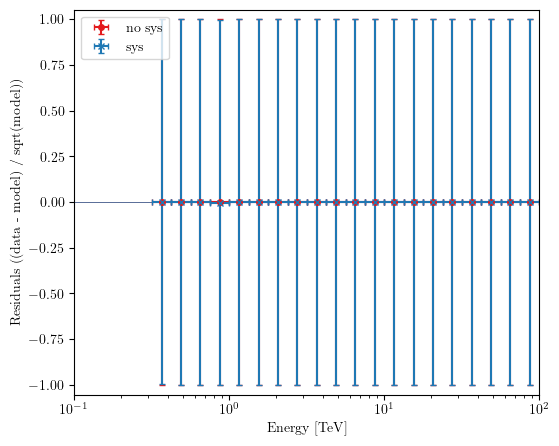

In [5]:
def plot_residuals_spec():
    fig,ax = plt.subplots(1, 1, figsize = (6, 5))
    
    energy_power = 2
    dataset.plot_residuals_spectral(ax  = ax, color = awo[0], method = 'diff/sqrt(model)',
                                   capsize = 2, label = "no sys")
    dataset_asimov_N.plot_residuals_spectral(ax  = ax, color = aw[0], method = 'diff/sqrt(model)',
                                         capsize = 2, marker = 'x', label = "sys")
    ax.legend()
    return ax
        
axs = plot_residuals_spec()
#axs[0].set_ylim(-5, 5)

(1e-13, 1e-10)

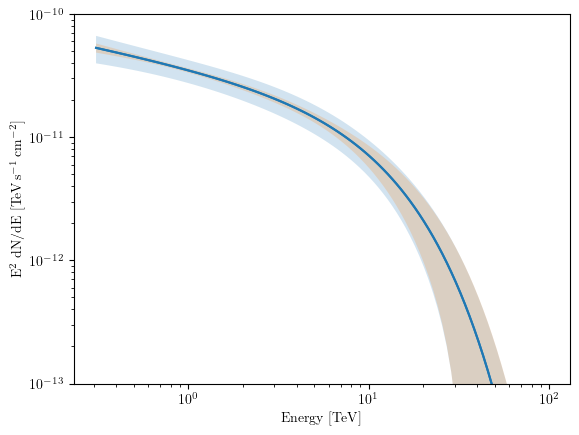

In [6]:
energy_power = 2
alpha = 0.8
energy_bounds = (0.3, 100) *u.TeV
fig, ax = plt.subplots()
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax)    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax, facecolor = 'tab:blue')  


dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax)    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax, facecolor = 'tab:orange')  

plt.ylim(1e-13, 1e-10)

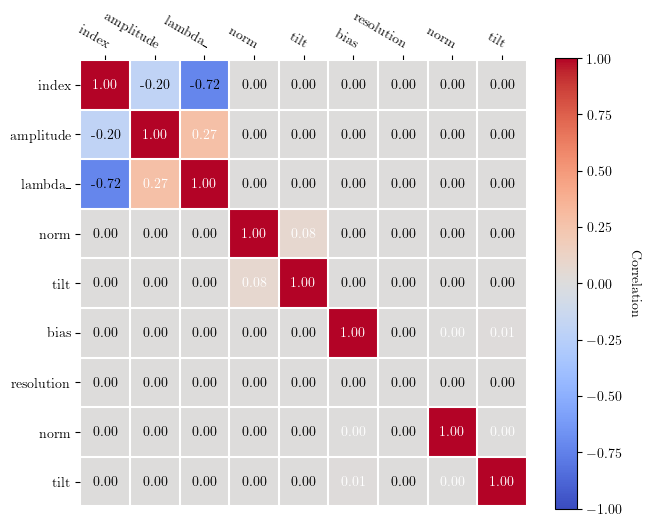

In [7]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm' , 
            'tilt']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
if fitting_N:

    parameters = Parameters([_ for _ in dataset_asimov_N.models.parameters if _.name in par_names])
    cov_par = dataset_asimov_N.models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/0_covmatrix.svg')
    fig.savefig(f'../{folder}/plots/0_covmatrix.pdf')



## Fluxpoints

In [ ]:
%%time
print("computing Fluxpoints")
computing = 1
if computing :

    energy_edges = dataset_asimov.geoms['geom'].axes[0].edges#[::2]


    dataset_asimov.models.parameters['amplitude'].scan_n_sigma  = 5
    dataset_asimov_N.models.parameters['amplitude'].scan_n_sigma  = 5

    esti  = FluxPointsEstimator(energy_edges= energy_edges[::2][:-1], 
                                selection_optional =  [ "ul"],
                                norm_min=0.2,
                            norm_max=200,
                            norm_n_values=15,
                               )
    fluxpoints = esti.run([dataset_asimov])
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fluxpoints.plot()

    # freeze all but IRF for fp and reopt = True
    dataset_asimov_N.models[0].parameters.freeze_all()
    dataset_asimov_N.models[0].parameters['amplitude'].frozen = False
    dataset_asimov_N.background_model.parameters.freeze_all()
    esti_  = FluxPointsEstimator(energy_edges= energy_edges[::2][:-1],
                                 selection_optional =[ "ul"],# "errn-errp", "all",
                                norm_min=0.2,
                            norm_max=200,
                            norm_n_values=15,
                               reoptimize=True)
    fluxpoints_N = esti_.run([dataset_asimov_N])
    fluxpoints_N.plot(ax = ax)
    ax.legend()
    fig.savefig(f"{folder}/plots/asimov_fluxpoints.png")

    fluxpoints_N.write(f'{folder}/data/fluxpoints_N.fits',
                      overwrite = True)
    fluxpoints.write(f'{folder}/data/fluxpoints.fits',
                    overwrite = True)


computing Fluxpoints

0.10000000000000002 TeV 0.1778279410038923 TeV
in parameter estimate best fit
in estimate_ts
in estimate_ul

0.1778279410038923 TeV 0.316227766016838 TeV
in parameter estimate best fit
in estimate_ts
in estimate_ul

0.316227766016838 TeV 0.5623413251903491 TeV
in parameter estimate best fit
models after fit:
DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ScaleSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    norm                       :      1.000  +/-    0.08             
    lon_0      (frozen)        :    329.680      deg         
    lat_0      (frozen)        :    -30.222      deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-bkg
  Datasets names            : ['dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm       (frozen)        : 

In [ ]:
energy_power = 2
alpha = 0.8
energy_bounds = (0.3, 100) *u.TeV
fig, ax = plt.subplots()
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax)    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax, facecolor = 'tab:blue')  


dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax)    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds, energy_power = energy_power,
                                             color = aw[0], ax = ax, facecolor = 'tab:orange')  

fluxpoints_N.plot(ax = ax)
fluxpoints.plot(ax = ax)


plt.ylim(1e-13, 1e-10)